In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### One dimensional diffusion

We can imagine a segment of length $2L$ under uniform pore pressure $p_0$. At $t=t_0$, the segment is drained from both ends. Assuming symmetry at $x=L$, we can write the problem for $x \isin [0, L]$ with this one dimensional differential equation:

$$ \frac{\partial p}{\partial t} - c\frac{\partial^2 p}{\partial x^2}=0, $$

also using those boundary conditions:
$$p(x=0, t>0) = 0,$$
$$\frac{\partial p}{\partial x}(x = L, t) = 0$$
and
$$p(x, t=0) = p_0.$$


We will start by defining a very simple one dimensional mesh, which we will use to compute finite differences.

In [3]:
# Mesh definition
L  = 1    # length of the domain
p0 = 1    # initial pressure
c  = 1    # consolidation coefficient
n  = 100  # number of elements

x = np.linspace(0, L, n + 1)
dx = x[1] - x[0]
print(f'{x=}')
print(f'{dx=}')


x=array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])
dx=0.01


### Finite differences

We can compute this differential equation as a system of equations by discretizing the pressure. We do so by computing a matrix $\mathbf{L}$.

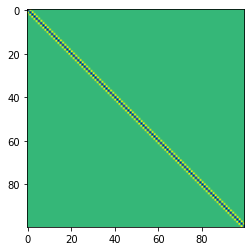

In [4]:
from scipy.sparse import lil_matrix
Lmat = lil_matrix((n, n))

for i in range(n):
    Lmat[i, i] = -2

    if i == 0:
        Lmat[i, i+1] = 1

    elif i == n - 1:
        Lmat[i, i - 1] = 1
        Lmat[i, i] = -1

    else:
        Lmat[i, i + 1] = 1
        Lmat[i, i - 1] = 1

Lmat = Lmat / dx / dx 
plt.imshow(Lmat.toarray())


In [5]:
theta = 0.8
dt =  30 * dx * dx / (2.0 * c)

t = np.arange(0, 1 + dt, dt)
print(len(t))
print(dt)
heads = np.zeros((len(t), n))
heads[0] = p0

from scipy.sparse import eye
from scipy.sparse import linalg
I = eye(n)

left = I - theta * c * dt * Lmat

for i in range(len(t) - 1):
    dp = linalg.spsolve(left, c * dt * Lmat.dot(heads[i]))
    heads[i + 1] = heads[i] + dp

668
0.0015


### Comparing with an analytical solution

The analytical solution for the pressure $p(x, t)$ is given by the following equation:

$$ p(x, t) = p_0 \sum_{k=1, 3, ..}^{\infty}\frac{4}{k\pi}\sin\left(\frac{k\pi x^*}{2}\right)\exp(-k^2 \pi^2 t^*),$$

where $x^*=\frac{x}{L}$ and $t^*=\frac{ct}{4L^2}$. We obviously can't compute the terms for values of $k$ all the way to infinity; we must choose a large enough number. As is usually done in python, we want to avoid using for loops and will use vectorization with ``numpy``'s ``meshgrid`` function.


In [50]:
def analytical_solution(x, t, L, c, p0=1, n=1e3):
    xstar = x/L
    tstar = c * t / (4 * L * L)
    k = np.arange(int(n))[1::2]

    # returns a tuple of shape (nk, nx, nt)
    xx, kk, tt = np.meshgrid(xstar, k, tstar)

    sinus = np.sin(0.5 * kk * np.pi * xx)
    exponent = np.exp(-kk * kk * np.pi * np.pi * tt)
    summed = np.sum(4 / (kk * np.pi) * sinus * exponent, axis=0)

    return p0 * summed

analytical_solution(x, 0, L, 1).shape

(101, 1)

Text(0, 0.5, 'pressure (m)')

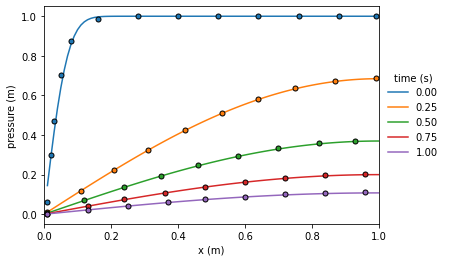

In [45]:
nlines = 5
for i, ti in enumerate(np.linspace(1, len(t) - 1, nlines).astype(int)):

    # we plot the analytical solution first as a line    
    l, = plt.plot(x[:-1] + dx, analytical_solution(x[:-1] + dx, t[ti], L, c), label=f'{t[ti]:.2f}')

    # we then plot the numerical solution on top as only points
    plt.plot(x[:-1] + dx, heads[ti], c=l.get_color(), ls='none', marker='.', markevery=0.1, ms=10, mec='k')

# fancy plotting
plt.legend(title='time (s)', loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.xlim(0, 1)
plt.xlabel('x (m)')
plt.ylabel('pressure (m)')

Text(0.0, 1.0, 'pressure (m)')

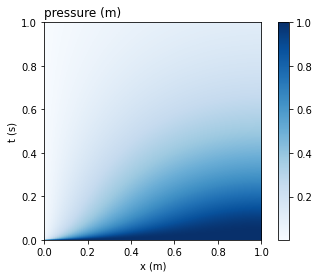

In [8]:
# we can show what the solution looks like everywhere in the domain
plt.imshow(heads, extent=[x[0], x[-1], t[0], t[-1]], origin='lower', cmap='Blues',)
plt.xlabel('x (m)')
plt.ylabel('t (s)')
cb = plt.colorbar()
plt.title('pressure (m)', loc='left')

In [51]:
# what about the error?
anal_heads = analytical_solution(x[:-1] + dx, t, L, c).T
error = 100 * (anal_heads - heads)/anal_heads

Text(0.0, 1.0, 'relative error (%)')

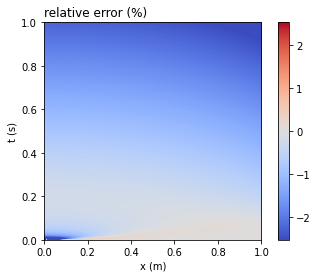

In [52]:
vmax = np.quantile(np.abs(error), 0.99)
# we can show what the solution looks like everywhere in the domain
plt.imshow(error, extent=[x[0], x[-1], t[0], t[-1]], origin='lower', cmap='coolwarm', vmin=-vmax, vmax=vmax)
plt.xlabel('x (m)')
plt.ylabel('t (s)')
cb = plt.colorbar()
plt.title('relative error (%)', loc='left')